# LiDAR Object Detection

## 1. Introduction to Lidar and Point Clouds

Setup the SFND_Obstacle_Detection tool

## 2. Point Cloud Segmentation

### a) Ground Filtering using RANSAC (Random Sample Consensus)

pcl tutorial on [segmentation](http://pointclouds.org/documentation/tutorials/#segmentation)

#### Using pcl RANSAC

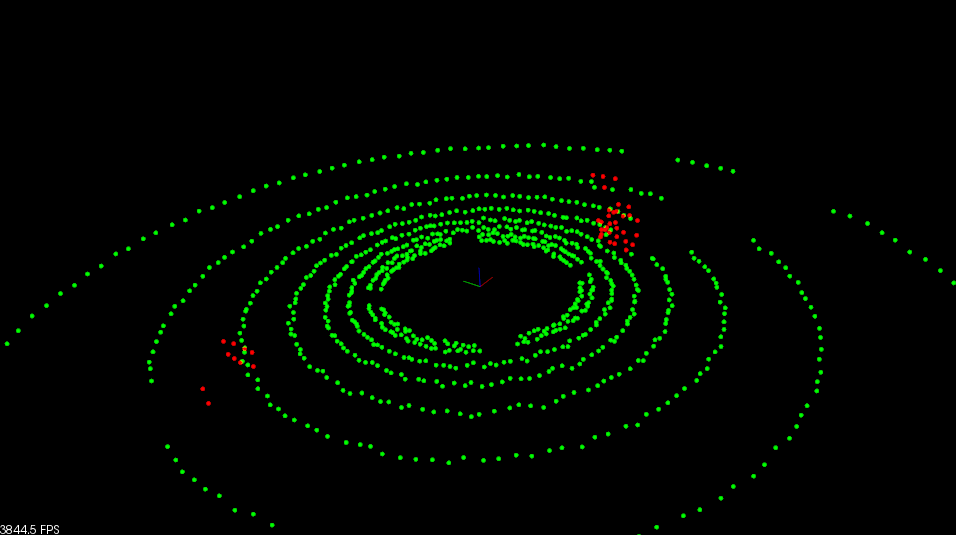



#### 2D RANSAC

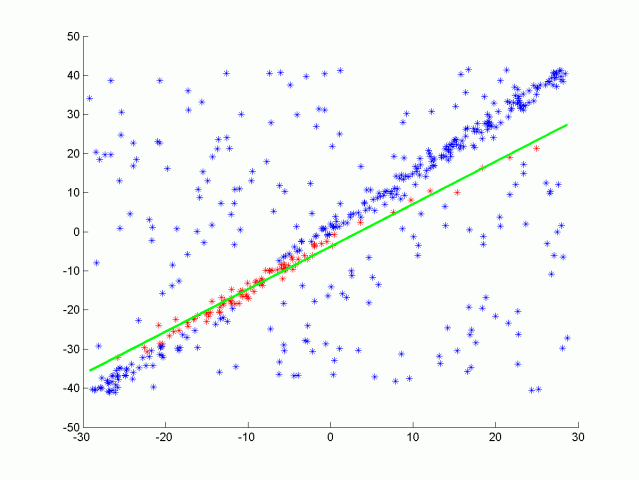

```c++
std::unordered_set<int> Ransac(pcl::PointCloud<pcl::PointXYZ>::Ptr cloud, int maxIterations, float distanceTol)
{
	auto startTime = std::chrono::steady_clock::now();
	std::unordered_set<int> inliersResult;
	srand(time(NULL));
	
	// TODO: Fill in this function

	// For max iterations 
	while (maxIterations--)
	{
		// Randomly sample subset and fit line
		std::unordered_set<int> inliers;
		while (inliers.size() < 2)
			inliers.insert(rand()%(cloud->points.size()));

		float x1, y1, x2, y2;

		auto iter = inliers.begin();
		x1 = cloud->points[*iter].x;
		y1 = cloud->points[*iter].y;
		iter++;
		x2 = cloud->points[*iter].x;
		y2 = cloud->points[*iter].y;

		float a = (y1 - y2);
		float b = (x2 - x1);
		float c = (x1*y2 - x2*y1);

		// Measure distance between every point and fitted line
		for (int index = 0; index < cloud->points.size(); index++)
		{
			if (inliers.count(index) > 0) 
				continue;

			pcl::PointXYZ point = cloud->points[index];
			float x3 = point.x;
			float y3 = point.y;

			// If distance is smaller than threshold count it as inlier
			float d = fabs(a*x3 + b*y3 + c)/sqrt(a*a + b*b);
			if (d <= distanceTol)
				inliers.insert(index);
		}

		// Return indicies of inliers from fitted line with most inliers
		if (inliers.size() > inliersResult.size())
			inliersResult = inliers;
	}
	
	auto endTime = std::chrono::steady_clock::now();
	auto elapsedTime = std::chrono::duration_cast<std::chrono::milliseconds>(endTime - startTime);
	std::cout << "RANSAC took " << elapsedTime.count() << " milliseconds" << std::endl;

	return inliersResult;

}
```

#### 3D RANSAC

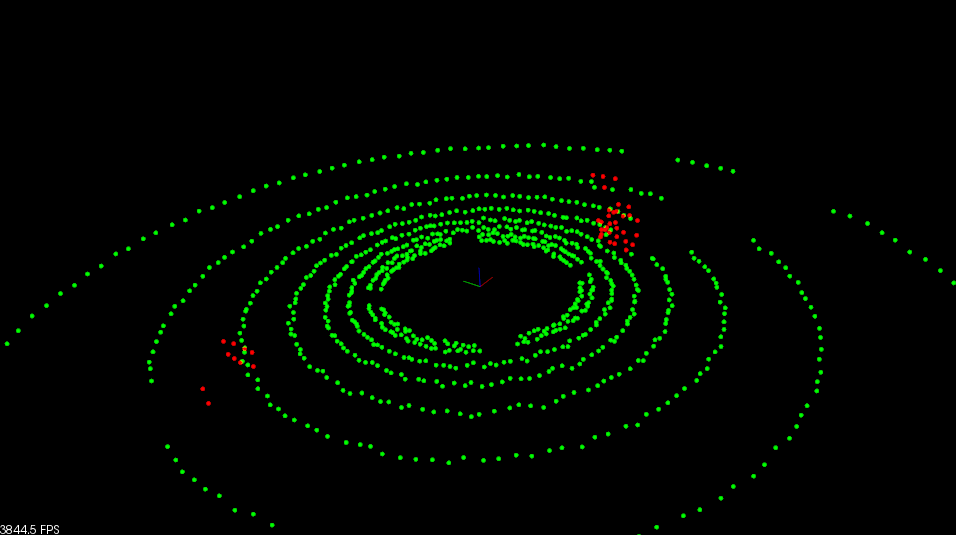

```c++
std::unordered_set<int> RansacPlane(pcl::PointCloud<pcl::PointXYZ>::Ptr cloud, int maxIterations, float distanceTol)
{
	auto startTime = std::chrono::steady_clock::now();
	std::unordered_set<int> inliersResult;
	srand(time(NULL));
	
	// TODO: Fill in this function

	// For max iterations 
	while (maxIterations--)
	{
		// Randomly sample subset and fit line
		std::unordered_set<int> inliers;
		while (inliers.size() < 3)
			inliers.insert(rand()%(cloud->points.size()));

		float x1, x2, x3, y1, y2, y3, z1, z2, z3;

		auto iter = inliers.begin();
		x1 = cloud->points[*iter].x;
		y1 = cloud->points[*iter].y;
		z1 = cloud->points[*iter].z;
	
		iter++;
		x2 = cloud->points[*iter].x;
		y2 = cloud->points[*iter].y;
		z2 = cloud->points[*iter].z;

		iter++;
		x3 = cloud->points[*iter].x;
		y3 = cloud->points[*iter].y;
		z3 = cloud->points[*iter].z;

		float A = (y2 - y1)*(z3 - z1) - (z2 - z1)*(y3 - y1);
		float B = (z2 - z1)*(x3 - x1) - (x2 - x1)*(z3 - z1);
		float C = (x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 - x1);
		float D = -(A*x1 + B*y1 + C*z1);

		// Measure distance between every point and fitted line
		for (int index = 0; index < cloud->points.size(); index++)
		{
			if (inliers.count(index) > 0) 
				continue;

			pcl::PointXYZ point = cloud->points[index];
			float x3 = point.x;
			float y3 = point.y;
			float z3 = point.z;

			// If distance is smaller than threshold count it as inlier
			float d = fabs(A*x3 + B*y3 + C*z3 + D)/sqrt(A*A + B*B + C*C);
			if (d <= distanceTol)
				inliers.insert(index);
		}

		// Return indicies of inliers from fitted line with most inliers
		if (inliers.size() > inliersResult.size())
			inliersResult = inliers;
	}
	
	auto endTime = std::chrono::steady_clock::now();
	auto elapsedTime = std::chrono::duration_cast<std::chrono::milliseconds>(endTime - startTime);
	std::cout << "RANSAC took " << elapsedTime.count() << " milliseconds" << std::endl;

	return inliersResult;

}
```

**Comparison:** This self-made version of 3D RANSAC function took 2 ms on the example point cloud while the pcl implementation took only 0 ms.


## 3. Clustering Obstacles

### a) KD-Tree
Speed-up look-up time from O(n) to O(log(n))
* Binary Tree
* Insert points alternating comparison between dimensions

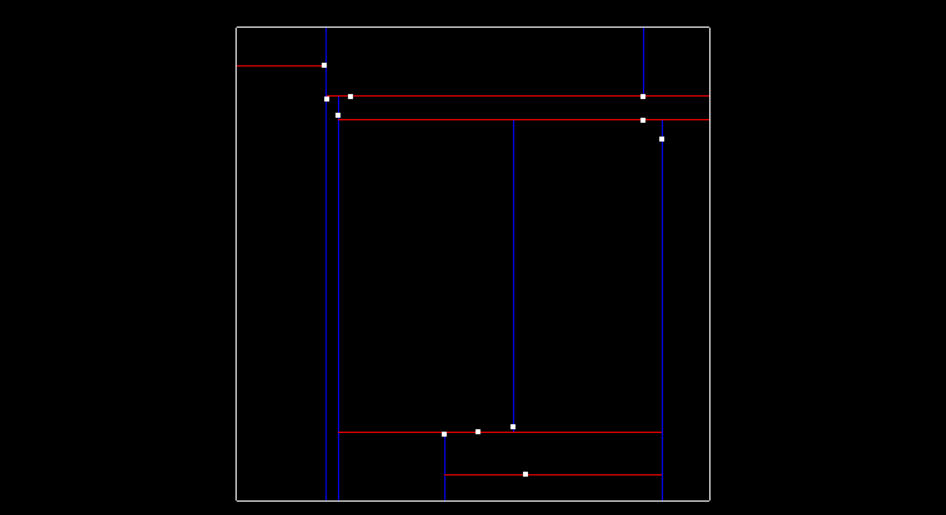

A KD-Tree is a binary tree that splits points between alternating axes. By separating space by splitting regions, nearest neighbor search can be made much faster when using an algorithm like euclidean clustering.

Now let’s talk about how exactly the tree is created. At the very beginning when the tree is empty, root is NULL. The point inserted becomes the root, and splits the x region. Here is what this visually looks like, after inserting the first point (-6.2, 7).

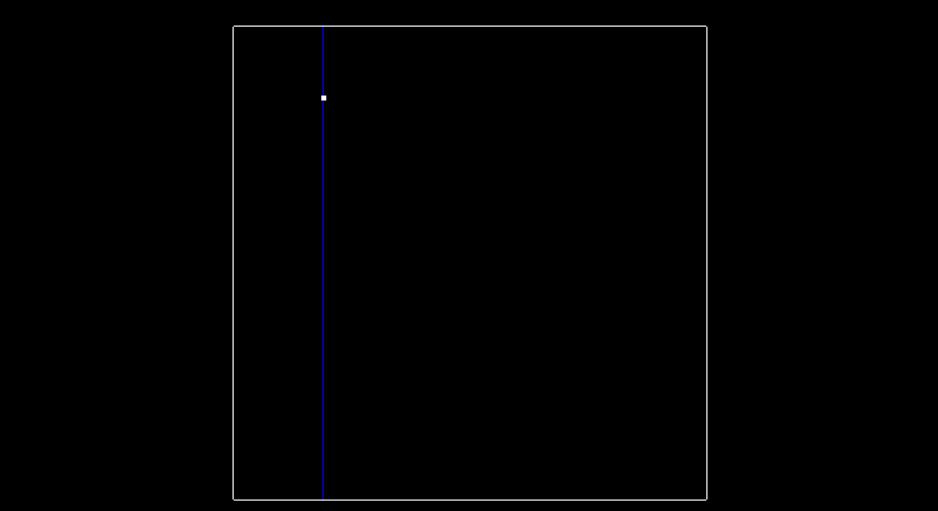

The next point is (-6.3, 8.4). Since we previously split in the x-dimension, and -6.3 is less than -6.2. This Node will be created and be a part of root's left node. The point (-6.3, 8.4) will split the region in the y dimension.

To recap, the root was at depth 0, and split the x region. The next point became the left child of root and had a depth of 1, and split the y region.

A point at depth 2 will split the x region again, so the split dimension number can actually be calculated as depth % 2, where 2 is the number of dimensions we are working with. The image below shows how the tree looks after inserting the second point.

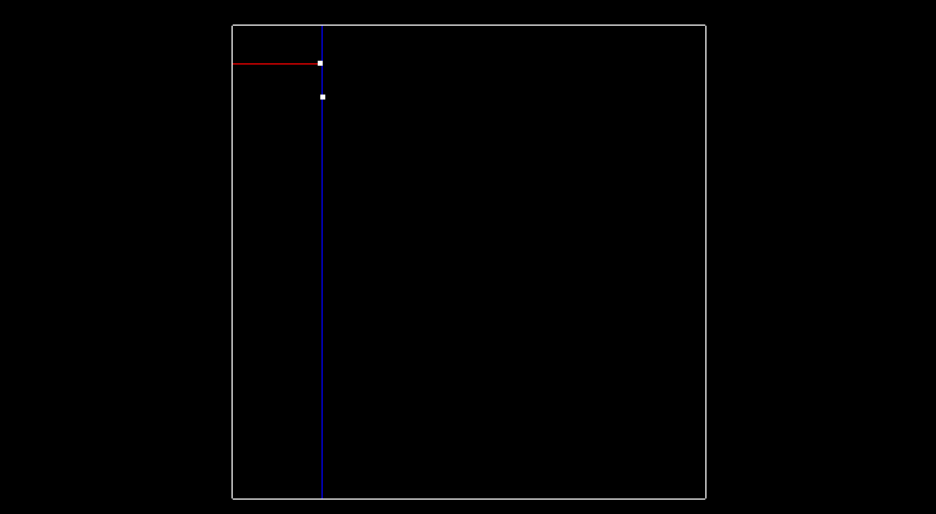

Then here is what the tree looks like after inserting two more points (-5.2, 7.1) and (-5.7, 6.3), and having another x split division from point (-5.7, 6.3). The tree is now at depth 2.

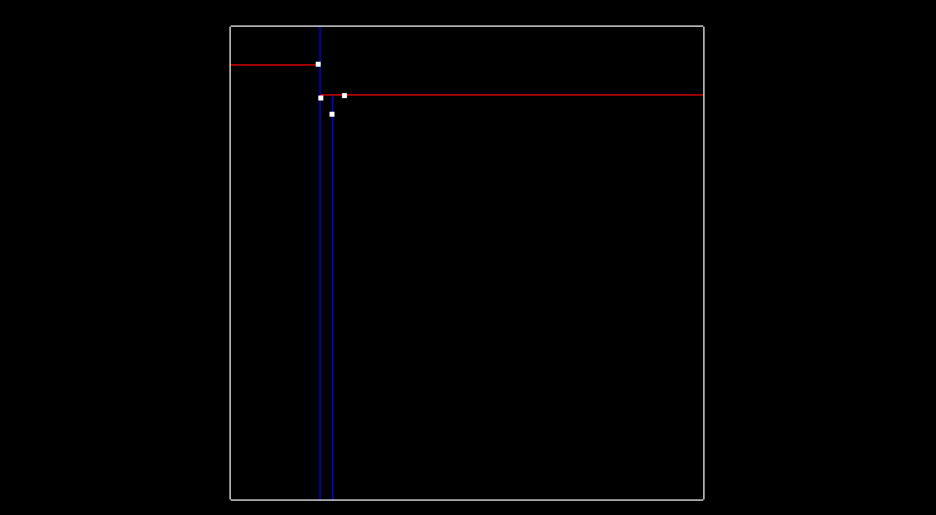

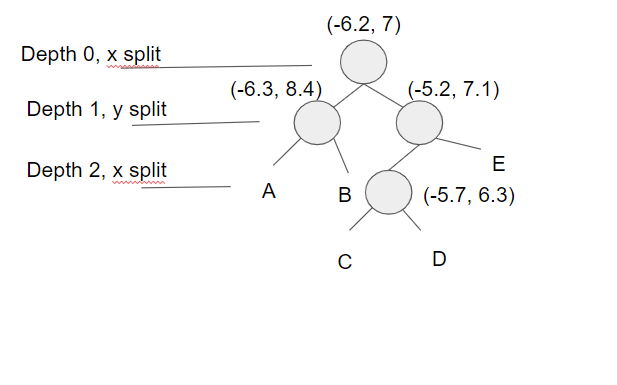

#### Improveing the Tree
Median values will split the regions more evenly
1. Sort the points based on their x values and y values
2. 2D Example: Insert the x median, then y median, then x median, ect

#### Searching Points in a KD-Tree

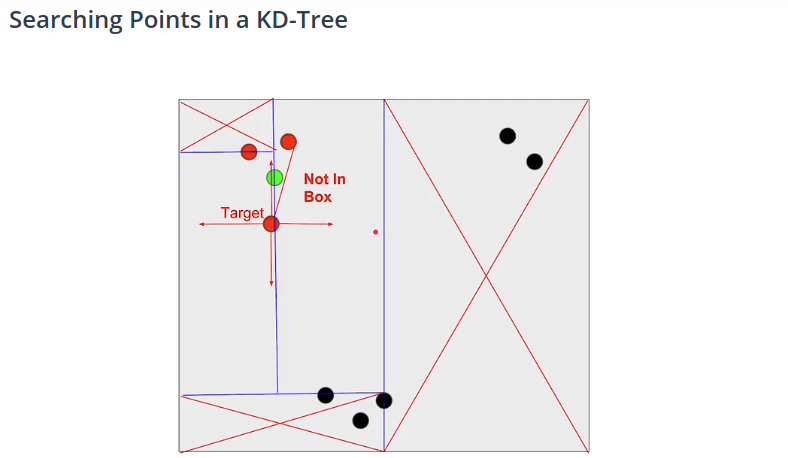

#### Implementing KD-Tree

```c++
struct Node
{
	std::vector<float> point;
	int id;
	Node* left;
	Node* right;

	Node(std::vector<float> arr, int setId)
	:	point(arr), id(setId), left(NULL), right(NULL)
	{}
};

struct KdTree
{
	Node* root;

	KdTree()
	: root(NULL)
	{}

	void insertHelper(Node** node, uint depth, std::vector<float> point, int id)
	{
		// Tree is empty
		if (*node == NULL)
			*node = new Node(point, id);
		else
		{
			// Calulate current dimension
			uint cd = depth % 2;

			if(point[cd] < ((*node)->point[cd]))
				insertHelper(&(*node)->left, depth + 1, point, id);
			else
				insertHelper(&(*node)->right, depth + 1, point, id);
		}
		
	}

	void insert(std::vector<float> point, int id)
	{
		// TODO: Fill in this function to insert a new point into the tree
		// the function should create a new node and place correctly with in the root 
		insertHelper(&root, 0, point, id);
	}

void searchHelper(std::vector<float> target, Node* node, int depth, float distanceTol, std::vector<int>& ids)
	{
		if (node != NULL)
		{
			if (node->point[0] >= (target[0] - distanceTol) && node->point[0] <= (target[0] + distanceTol)
				&& node->point[1] >= (target[1] - distanceTol) && node->point[1] <= (target[1] + distanceTol))
			{
				float distance = sqrt((node->point[0] - target[0])*(node->point[0] - target[0]) 
									+ (node->point[1] - target[1])*(node->point[1] - target[1]));
				if (distance <= distanceTol)
					ids.push_back(node->id);
			}

			// check accross boundary
			if ((target[depth%2] - distanceTol) < node->point[depth%2])
				searchHelper(target, node->left, depth + 1, distanceTol, ids);
			if ((target[depth%2] + distanceTol) > node->point[depth%2])
				searchHelper(target, node->right, depth + 1, distanceTol, ids);
		}
	}
	
	// return a list of point ids in the tree that are within distance of target
	std::vector<int> search(std::vector<float> target, float distanceTol)
	{
		std::vector<int> ids;
		searchHelper(target, root, 0, distanceTol, ids);

		return ids;
	}

};

```


### b) Euclidean Clustering

#### Clustering Using pcl

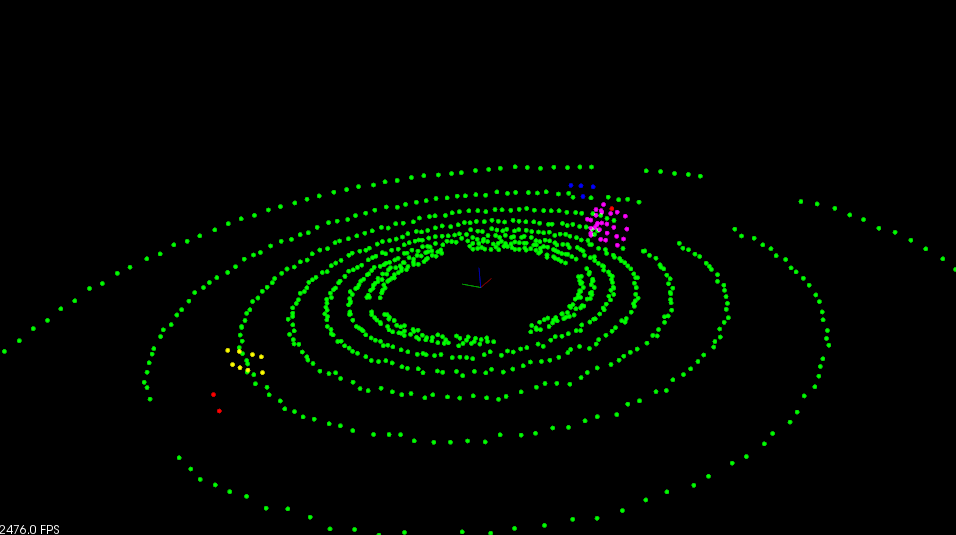


#### Implementing 2D Euclidean Clustering

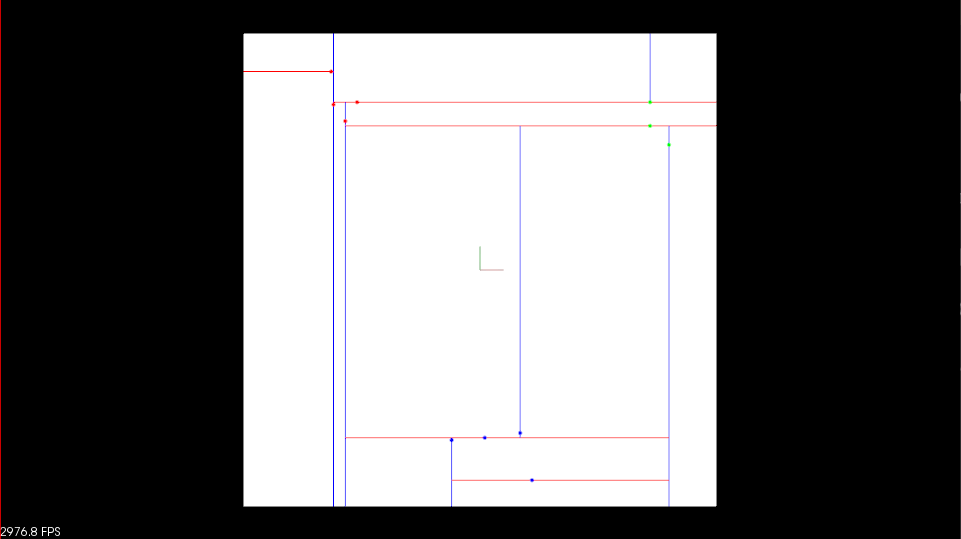

```c++
void clusterHelper(int indice, const std::vector<std::vector<float>> points, std::vector<int>& cluster, std::vector<bool>& processed, KdTree* tree, float distanceTol)
{
	processed[indice] = true;
	cluster.push_back(indice);

	std::vector<int> nearest = tree->search(points[indice], distanceTol);

	for (int id : nearest)
	{
		if (!processed[id])
			clusterHelper(id, points, cluster, processed, tree, distanceTol);
	}
}

std::vector<std::vector<int>> euclideanCluster(const std::vector<std::vector<float>>& points, KdTree* tree, float distanceTol)
{
	// TODO: Fill out this function to return list of indices for each cluster
	std::vector<std::vector<int>> clusters;

	std::vector<bool> processed(points.size(), false);
	
	int i = 0;
	while (i < points.size())
	{
		if (processed[i])
		{
			i++;
			continue;
		}
		
		std::vector<int> cluster;
		clusterHelper(i, points, cluster, processed, tree, distanceTol);
		clusters.push_back(cluster);
		i++;
	}

	return clusters;

}

```



### c) Bounding Boxes

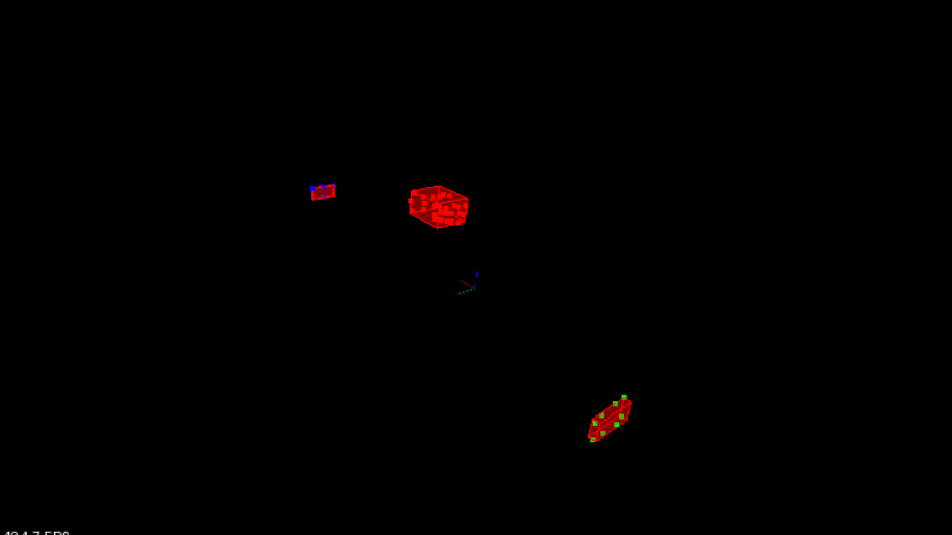

### d) Minimum Bounding Box
Principal Component Analysis (PCA) Boxes

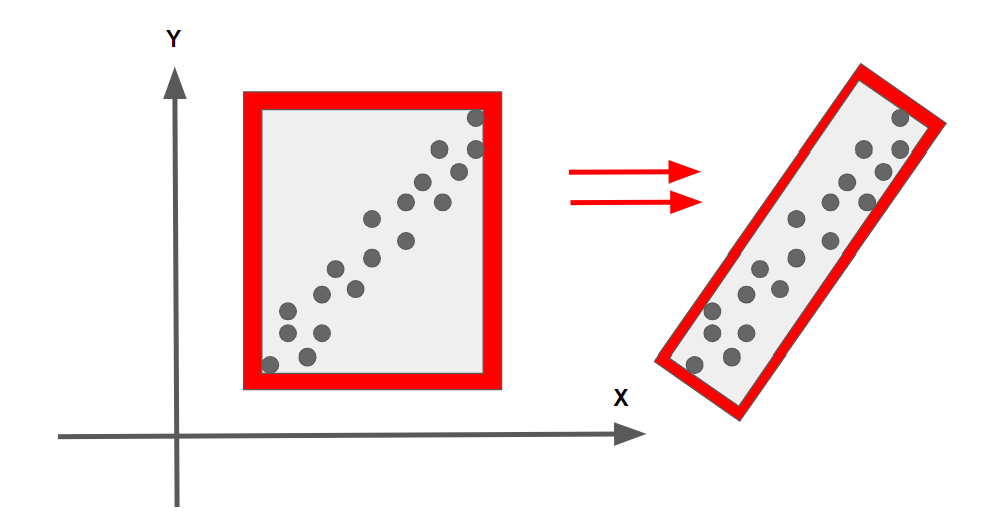

In the above image, the bounding box on the right is more efficient, containing all the points with the minimum area required. It would be nice to take into account box rotation in the XY plane, about the Z axis. Rotation about the X or Y axes would yield weird results, since the car in the majority of situations is not concerned with the Z dimension, or has any control over Z movement.

The file containing the box struct is located in `src/render/box.h` and contains an additional struct called `BoxQ`. This struct has a quaternion member that allows rotations. Also there is an additional `renderBox` function in `render.cpp` that takes a `BoxQ` argument and renders the rotational box. There is a blog post about fitting the smallest possible 3D box around a 3D point cloud [here](http://codextechnicanum.blogspot.com/2015/04/find-minimum-oriented-bounding-box-of.html). The solution in the post uses [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), principal component analysis and includes Z axis rotations as well. A challenge problem is then to find the smallest fitting box but which is oriented flat with the XY plane.

#### Process

1. compute the centroid (c0, c1, c2) and the normalized covariance
2. compute the eigenvectors e0, e1, e2. The reference system will be (e0, e1, e0 X e1) --- note: e0 X e1 = +/- e2
3. move the points in that RF --- note: the transformation given by the rotation matrix (e0, e1, e0 X e1) & (c0, c1, c2) must be inverted
4. compute the max, the min and the center of the diagonal
5. given a box centered at the origin with size (max_pt.x - min_pt.x, max_pt.y - min_pt.y, max_pt.z - min_pt.z) the transformation you have to apply is Rotation = (e0, e1, e0 X e1) & Translation = Rotation * center_diag + (c0, c1, c2)



## 4. Working with Real PCD

### a) Load PCD

```c++
ProcessPointClouds<pcl::PointXYZI>* pointProcessorI = new ProcessPointClouds<pcl::PointXYZI>();
    pcl::PointCloud<pcl::PointXYZI>::Ptr inputCloud = pointProcessorI->loadPcd("../src/sensors/data/pcd/data_1/0000000000.pcd");
    renderPointCloud(viewer, inputCloud, "inputCloud");

```

### b) Filering with PCL

